# Block Group Preliminary Modeling

In [2]:
import pandas as pd
import numpy as np
import pipeline_jmidkiff as pipeline
import warnings
# Many models give warnings which would be cumbersome to print
warnings.filterwarnings('ignore') 

In [119]:
# Importing final_df from 'Final Notebook': 
water_clean = pd.read_csv('data/final_df.csv', index_col=0)
high_block_groups = water_clean['threshold_high'].sum()
medium_block_groups = water_clean['threshold_medium'].sum()
print(f'''
Of the total {water_clean.shape[0]} block groups with any lead test results, 
{high_block_groups} block groups had at least 
one residence with a sample test result at or 
above 15.0 lead ppb - this was {round(high_block_groups / water_clean.shape[0] * 100, 1)}%.

{medium_block_groups} block groups had at least 
one residence with a sample test result at or 
above 5.0 lead ppb - this was {round(medium_block_groups / water_clean.shape[0] * 100, 1)}%.
''')

pipeline.show(water_clean)

# All block groups with a 'threshold_high' classification also 
# have a 'threshold_medium' classification. 


Of the total 2053 block groups with any lead test results, 
542 block groups had at least 
one residence with a sample test result at or 
above 15.0 lead ppb - this was 26.4%.

1521 block groups had at least 
one residence with a sample test result at or 
above 15.0 lead ppb - this was 74.1%.


Shape:
(2053, 60)

Data Types:
hh_size                                                          float64
med_income                                                       float64
occ_units                                                        float64
med_rent                                                         float64
oo_hsng_units                                                    float64
perc_white                                                       float64
perc_non_white                                                   float64
perc_black                                                       float64
perc_owner_occ                                                   float64
tot_pop        

,hh_size,med_income,occ_units,med_rent,oo_hsng_units,perc_white,perc_non_white,perc_black,perc_owner_occ,tot_pop,...,Roof Material_nan,Repair Condition_1.0,Repair Condition_2.0,Repair Condition_3.0,Repair Condition_nan,Renovation_1.0,Renovation_2.0,Renovation_nan,threshold_high,threshold_medium
0,1.95,NaN,236.0,873.0,117.0,0.574837,0.425163,0.234273,0.495763,461.0,...,0.801619,0.004049,0.190283,0.004049,0.801619,0.000000,0.0,1.000000,0,1
2,1.50,54297.0,1073.0,1071.0,327.0,0.663361,0.336639,0.249125,0.304753,1714.0,...,0.924528,0.006289,0.069182,0.000000,0.924528,0.002096,0.0,0.997904,0,0
3,2.30,42778.0,712.0,1097.0,224.0,0.280774,0.719226,0.436694,0.314607,1706.0,...,0.625442,0.000000,0.371025,0.003534,0.625442,0.000000,0.0,1.000000,0,1
4,2.69,39535.0,1424.0,1152.0,353.0,0.542930,0.457070,0.300637,0.247893,3925.0,...,0.787551,0.000000,0.211096,0.001353,0.787551,0.000000,0.0,1.000000,0,1
5,2.99,52948.0,611.0,1023.0,114.0,0.465461,0.534539,0.326206,0.186579,1824.0,...,0.694190,0.000000,0.305810,0.000000,0.694190,0.000000,0.0,1.000000,0,1


In [9]:
water_classification = pipeline.impute_missing(water_clean)
# Of note, all property class 299 (condominiums) have NaN for building square feet, 
# but many other property classes do as well. 
# Total Building Square Feet was unfortunately all NaN for Property Class 299, despite 
# what the documentation said. 

Contains NA Values:
hh_size                                                           True
med_income                                                        True
occ_units                                                        False
med_rent                                                          True
oo_hsng_units                                                    False
perc_white                                                       False
perc_non_white                                                   False
perc_black                                                       False
perc_owner_occ                                                    True
tot_pop                                                          False
('PIN', 'count')                                                 False
('Prior Tax Year Market Value Estimate (Land)', 'mean')          False
('Prior Tax Year Market Value Estimate (Land)', 'median')        False
('Prior Tax Year Market Value Estimate (Building)', 'mean

In [10]:
scaler = pipeline.normalized_values(
    water_classification, ignore=['threshold_high', 'threshold_medium'], quiet=True)

In [13]:
water_classification = pipeline.normalize(
    water_classification, scaler, ignore=['threshold_high', 'threshold_medium'], 
    inplace=True)
water_classification

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.pipeline import Pipeline as pipe_sklearn
# Split training and test data for both the 'high' and 'medium' categorizations
training, test = train_test_split(
    water_classification, test_size=0.2, random_state=0)
training_high_x, training_high_y = (
    training.drop(columns=['threshold_high', 'threshold_medium']),
    training['threshold_high'])
test_high_x, test_high_y = (
    test.drop(columns=['threshold_high', 'threshold_medium']), 
    test['threshold_high'])
training_med_x, training_med_y = (
    training.drop(columns=['threshold_high', 'threshold_medium']),
    training['threshold_medium'])
test_med_x, test_med_y = (
    test.drop(columns=['threshold_high', 'threshold_medium']), 
    test['threshold_medium'])

In [61]:
# Creating the pipeline and the grid of parameters to apply to the Logistic 
# regressions, with 10-fold validation
pipe = pipe_sklearn([
    ('LogisticRegression', LogisticRegression(max_iter=5000))
])
params = {
    'LogisticRegression__penalty': ['l1', 'l2', 'none'], 
    'LogisticRegression__solver': ['lbfgs', 'liblinear'],
    'LogisticRegression__C': [1000, 100, 10, 1, 0.1, 0.01, 0.001]
}
k = 10

## Logistic Classification of High (15.0+) Lead PBB Test Results

In [62]:
grid_model_high = GridSearchCV(estimator=pipe, 
                          param_grid=params, 
                          cv=10, 
                          scoring=['accuracy', 'precision', 'recall'], 
                          refit='accuracy')
grid_model_high_result = grid_model_high.fit(training_high_x, training_high_y)

In [63]:
p_high = grid_model_high_result.best_params_
test_score = grid_model_high_result.score(
    X=test_high_x,
    y=test_high_y)
print(f'''
The most accurate model was a Logistic Regression with the following parameters: 
C: {p_high['LogisticRegression__C']}
Penalty: {p_high['LogisticRegression__penalty']}
Solver: {p_high['LogisticRegression__solver']}

It had a mean validation set accuracy of {round(grid_model_high.best_score_, 4)}.
On the test data it had an accuracy of {round(test_score, 4)}.

This model is index #{grid_model_high_result.best_index_} in the below table. 
''')
results_high_df = pd.DataFrame.from_dict(grid_model_high_result.cv_results_)[[
    'param_LogisticRegression__C', 'param_LogisticRegression__penalty',
    'param_LogisticRegression__solver',
    'mean_test_accuracy', 'rank_test_accuracy', 'mean_test_precision', 
    'rank_test_precision', 'mean_test_recall', 'rank_test_recall'
]]
# Gets rid of models where the solvers and params are incompatible
results_high_df.dropna(axis=0) 


The most accurate model was a Logistic Regression with the following parameters: 
C: 0.01
Penalty: l2
Solver: liblinear

It had a mean validation set accuracy of 0.754.
On the test data it had an accuracy of 0.7567.

This model is index #33 in the below table. 



,param_LogisticRegression__C,param_LogisticRegression__penalty,param_LogisticRegression__solver,mean_test_accuracy,rank_test_accuracy,mean_test_precision,rank_test_precision,mean_test_recall,rank_test_recall
1,1000,l1,liblinear,0.750314,6,0.548878,10,0.261575,3
2,1000,l2,lbfgs,0.749704,19,0.546885,24,0.259249,14
3,1000,l2,liblinear,0.749704,19,0.546885,24,0.259249,14
4,1000,none,lbfgs,0.750314,6,0.548878,10,0.261575,3
7,100,l1,liblinear,0.750314,6,0.548878,10,0.261575,3
8,100,l2,lbfgs,0.750314,6,0.548878,10,0.261575,3
9,100,l2,liblinear,0.750314,6,0.548878,10,0.261575,3
10,100,none,lbfgs,0.750314,6,0.548878,10,0.261575,3
13,10,l1,liblinear,0.749701,23,0.548221,21,0.256924,18
14,10,l2,lbfgs,0.749704,19,0.547881,22,0.259249,14


In [64]:
best_model_high = LogisticRegression(
    C=p_high['LogisticRegression__C'], 
    penalty=p_high['LogisticRegression__penalty'], 
    solver=p_high['LogisticRegression__solver'], max_iter=5000)
best_model_high.fit(X=training_high_x, y=training_high_y)
pipeline.print_coefs(
    best_model_high, df=training.drop(columns=['threshold_medium']), 
    target='threshold_high', n=100)

Target:
threshold_high

Intercept:
[-0.85631668]

Features and Coefficients:
Property Class_205.0                                             0.181307
tot_pop                                                          0.133233
med_income                                                       0.132023
perc_owner_occ                                                   0.114570
oo_hsng_units                                                    0.112574
Property Class_204.0                                             0.099522
Property Class_208.0                                             0.076595
('Prior Tax Year Market Value Estimate (Land)', 'mean')          0.068317
Wall Material_3.0                                                0.066599
perc_white                                                       0.064589
('Age', 'median')                                                0.060445
Property Class_203.0                                             0.058510
Property Class_234.0               

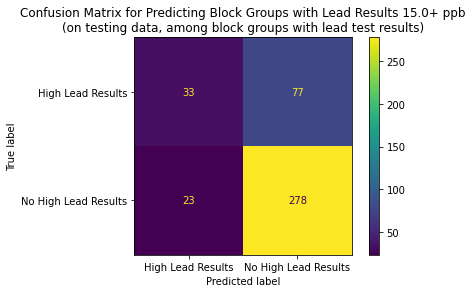


Test Accuracy: 0.7567
Test Precision: 0.5893
Test Recall: 0.3



In [106]:
import matplotlib.pyplot as plt # Don't overwrite plt !
from sklearn.metrics import plot_confusion_matrix, accuracy_score, precision_score, recall_score

cm = plot_confusion_matrix(
    estimator=best_model_high, 
    X=test_high_x, y_true=test_high_y, labels=[1,0], 
    display_labels=['High Lead Results', 'No High Lead Results'])
plt.grid(linestyle='')
plt.title('Confusion Matrix for Predicting Block Groups with Lead Results 15.0+ ppb\n' + 
         '(on testing data, among block groups with lead test results)')
plt.show()

accuracy = accuracy_score(y_true=test_high_y, y_pred=best_model_high.predict(test_high_x))
precision = precision_score(y_true=test_high_y, y_pred=best_model_high.predict(test_high_x))
recall = recall_score(y_true=test_high_y, y_pred=best_model_high.predict(test_high_x))

print(f'''
Test Accuracy: {round(accuracy, 4)}
Test Precision: {round(precision, 4)}
Test Recall: {round(recall, 4)}
''')

In [116]:
probs_high = pd.DataFrame(
    best_model_high.predict_proba(
        X=water_classification.drop(columns=['threshold_high', 'threshold_medium'])), 
    index=water_classification.index).merge(
)

,0,1
0,0.817166,0.182834
2,0.789814,0.210186
3,0.781959,0.218041
4,0.784862,0.215138
5,0.792913,0.207087
...,...,...
2186,0.670861,0.329139
2188,0.846599,0.153401
2189,0.926477,0.073523
2190,0.908164,0.091836


## Logistic Classification of Medium (5.0+) Lead PBB Test Results

In [69]:
grid_model_med = GridSearchCV(estimator=pipe, 
                          param_grid=params, 
                          cv=10, 
                          scoring=['accuracy', 'precision', 'recall'], 
                          refit='accuracy')
grid_model_med_result = grid_model_med.fit(training_med_x, training_med_y)

In [70]:
p_med = grid_model_med_result.best_params_
test_score = grid_model_med_result.score(
    X=test_med_x,
    y=test_med_y)
print(f'''
The best model was a Logistic Regression with the following parameters: 
C: {p_med['LogisticRegression__C']}
Penalty: {p_med['LogisticRegression__penalty']}
Solver: {p_med['LogisticRegression__solver']}

It had a mean validation set accuracy of {round(grid_model_med.best_score_, 4)}.
On the test data it had an accuracy of {round(test_score, 4)}.

This model is index #{grid_model_med_result.best_index_} in the below table. 
''')

results_med_df = pd.DataFrame.from_dict(grid_model_med_result.cv_results_)[[
    'param_LogisticRegression__C', 'param_LogisticRegression__penalty',
    'param_LogisticRegression__solver',
    'mean_test_accuracy', 'rank_test_accuracy', 'mean_test_precision', 
    'rank_test_precision', 'mean_test_recall', 'rank_test_recall'
]]
# Gets rid of models where the solvers and params are incompatible
results_med_df.dropna(axis=0) 


The best model was a Logistic Regression with the following parameters: 
C: 100
Penalty: l1
Solver: liblinear

It had a mean validation set accuracy of 0.8106.
On the test data it had an accuracy of 0.7908.

This model is index #7 in the below table. 



,param_LogisticRegression__C,param_LogisticRegression__penalty,param_LogisticRegression__solver,mean_test_accuracy,rank_test_accuracy,mean_test_precision,rank_test_precision,mean_test_recall,rank_test_recall
1,1000,l1,liblinear,0.808769,17,0.838372,19,0.920618,16
2,1000,l2,lbfgs,0.808769,17,0.837816,20,0.921438,6
3,1000,l2,liblinear,0.808769,17,0.837816,20,0.921438,6
4,1000,none,lbfgs,0.809379,9,0.838428,12,0.921438,6
7,100,l1,liblinear,0.810595,1,0.840247,3,0.920618,16
8,100,l2,lbfgs,0.809989,2,0.839626,7,0.920618,16
9,100,l2,liblinear,0.809989,2,0.839626,7,0.920618,16
10,100,none,lbfgs,0.809379,9,0.838428,12,0.921438,6
13,10,l1,liblinear,0.809375,16,0.839505,10,0.919799,20
14,10,l2,lbfgs,0.809985,5,0.840133,4,0.919799,20


In [71]:
best_model_med = LogisticRegression(
    C=p_med['LogisticRegression__C'], 
    penalty=p_med['LogisticRegression__penalty'], 
    solver=p_med['LogisticRegression__solver'], max_iter=5000)
best_model_med.fit(X=training_med_x, y=training_med_y)
pipeline.print_coefs(
    best_model_med, df=training.drop(columns=['threshold_high']), 
    target='threshold_medium', n=100)

Target:
threshold_medium

Intercept:
[1.75656962]

Features and Coefficients:
tot_pop                                                          0.929415
('Prior Tax Year Market Value Estimate (Building)', 'median')    0.766888
perc_owner_occ                                                   0.548346
Roof Material_1.0                                                0.509839
Property Class_234.0                                             0.436696
('Prior Tax Year Market Value Estimate (Land)', 'mean')          0.414314
Property Class_205.0                                             0.353384
Roof Material_2.0                                                0.329357
Property Class_278.0                                             0.295268
Wall Material_2.0                                                0.292112
Property Class_299.0                                             0.273938
Wall Material_4.0                                                0.201237
Repair Condition_2.0              

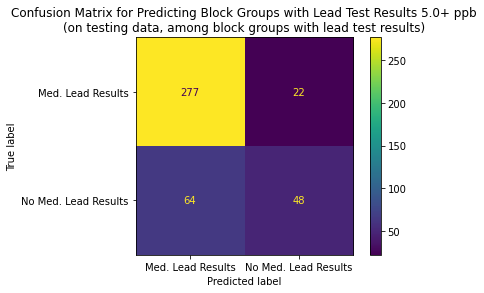


Test Accuracy: 0.7908
Test Precision: 0.8123
Test Recall: 0.9264



In [107]:
plot_confusion_matrix(
    estimator=best_model_med, 
    X=test_med_x, y_true=test_med_y, labels=[1,0], 
    display_labels=['Med. Lead Results', 'No Med. Lead Results'])
plt.grid(linestyle='')
plt.title('Confusion Matrix for Predicting Block Groups with Lead Test Results 5.0+ ppb\n' + 
         '(on testing data, among block groups with lead test results)')
plt.show()

accuracy = accuracy_score(y_true=test_med_y, y_pred=best_model_med.predict(test_med_x))
precision = precision_score(y_true=test_med_y, y_pred=best_model_med.predict(test_med_x))
recall = recall_score(y_true=test_med_y, y_pred=best_model_med.predict(test_med_x))

print(f'''
Test Accuracy: {round(accuracy, 4)}
Test Precision: {round(precision, 4)}
Test Recall: {round(recall, 4)}
''')

## Interpretation of Results

To restate, we ran two logistic models to predict block groups that have at least one residence with one water sample test that measure at least 15.0 lead ppb (high lead result) and at least 5.0 lead ppb (medium lead result). The best logistic models' accuracy was in the 75-79%, but this masked significant variation both between and within the models. 

There was some agreement on the most important features in both models, as the below table indicates, with several features showing up among the top 10 in both models:  

| Feature | Affect on Likelihood of Elevated Lead Results | High Results Feature Rank | Med. Results Feature Rank |
|-----|-----|-----|-----|
|Property Class_205.0| Increased |1|7|
| tot_pop | Increased | 2 | 1|
|perc_owner_occ|Increased|4|3|
|Prior Tax Year Market Value Estimate (Land), mean|Increased|8|6|


| Feature | Affect on Likelihood of Elevated Lead Results | High Results Feature Rank | Med. Results Feature Rank |
|-----|-----|-----|-----|
|Property Class 211.0| Decreased|1|2|
|hh_size|Decreased|2|3|
|perc_non_white|Decreased|3|4|
|Building Square Feet, median|Decreased|4|8|
|Renovation_NaN|Decreased|9|9

##### High Lead Model Result
The most accurate model had an accuracy of 75.7%, but its precision was only 58.9% and its recall was a much lower 30.0%. 